In [1]:
import os
import re
import pandas as pd
import talknize_module as tk

# データの保存先ファイル
output_file = 'data/tcfd_target.csv'

# 読み取るデータ項目
columns_to_extract = ["書類管理番号", "書類名", "EDINET(ファンド)コード", "提出者(ファンド)", "提出者法人番号"]
# 追加のデータ項目
columns_to_extract.extend(["XBRLファイル名", "XBRLファイルパス"])

# 結果を格納するリスト
result_data = []

# data/XBRLフォルダのパス
base_dir = 'data/XBRL'

# Xbrl_Searchで始まるフォルダを取得
folders = [folder for folder in os.listdir(base_dir) if folder.startswith('Xbrl_Search')]

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    csv_file = os.path.join(folder_path, 'XbrlSearchDlInfo.csv')
    
    if os.path.exists(csv_file):
        # CSVファイルを読み込む (Shift_JISエンコーディング)
        df = pd.read_csv(csv_file, header=1, encoding='shift_jis')
        if not df.empty:
            # 指定された列のデータを取得
            data_row = df.iloc[0][columns_to_extract[:-2]].to_dict()
            # 書類管理番号を取得
            doc_number = data_row["書類管理番号"]
            
            # XBRLファイルのパス
            xbrl_folder = os.path.join(folder_path, doc_number, 'XBRL', 'PublicDoc')
            if os.path.exists(xbrl_folder):
                # XBRLファイル名を取得
                xbrl_files = [file for file in os.listdir(xbrl_folder) if file.endswith('.xbrl')]
                if xbrl_files:
                    # 最初のXBRLファイル名とそのパスを取得
                    xbrl_file_name = xbrl_files[0]
                    data_row["XBRLファイル名"] = xbrl_file_name
                    data_row["XBRLファイルパス"] = os.path.join(xbrl_folder, xbrl_file_name)
                else:
                    data_row["XBRLファイル名"] = ""
                    data_row["XBRLファイルパス"] = ""
            else:
                data_row["XBRLファイル名"] = ""
                data_row["XBRLファイルパス"] = ""
            
            # 結果に追加
            result_data.append(data_row)

# 結果をデータフレームに変換
result_df = pd.DataFrame(result_data, columns=columns_to_extract)

# 結果をCSVファイルに保存
result_df.to_csv(output_file, index=False, encoding='utf-8-sig')

#print(f"{len(result_data)} 件のデータを {output_file} に保存しました。")
result_df.head(30)

,書類管理番号,書類名,EDINET(ファンド)コード,提出者(ファンド),提出者法人番号,XBRLファイル名,XBRLファイルパス
0,S100TOGW,有価証券報告書,E01739,三菱電機株式会社,4010001008772,jpcrp030000-asr-001_E01739-000_2024-03-31_01_2...,data/XBRL/Xbrl_Search_20240709_152741/S100TOGW...
1,S100TQ91,有価証券報告書,E00877,旭化成株式会社,5120001059606,jpcrp030000-asr-001_E00877-000_2024-03-31_01_2...,data/XBRL/Xbrl_Search_20240710_170604/S100TQ91...
2,S100T4MO,有価証券報告書,E00395,キリンホールディングス株式会社,5010001034768,jpcrp030000-asr-001_E00395-000_2023-12-31_01_2...,data/XBRL/Xbrl_Search_20240717_123337/S100T4MO...
3,S100TW27,有価証券報告書,E00642,王子ホールディングス株式会社,5010001034743,jpcrp030000-asr-001_E00642-000_2024-03-31_01_2...,data/XBRL/Xbrl_Search_20240717_123457/S100TW27...
4,S100TU89,有価証券報告書,E11873,日本製紙株式会社,8011501009422,jpcrp030000-asr-001_E11873-000_2024-03-31_01_2...,data/XBRL/Xbrl_Search_20240717_123521/S100TU89...
5,S100TVNI,有価証券報告書,E00644,三菱製紙株式会社,8010001008769,jpcrp030000-asr-001_E00644-000_2024-03-31_01_2...,data/XBRL/Xbrl_Search_20240717_123541/S100TVNI...
6,S100TT3P,有価証券報告書,E00645,北越コーポレーション株式会社,6110001023149,jpcrp030000-asr-001_E00645-000_2024-03-31_01_2...,data/XBRL/Xbrl_Search_20240717_123609/S100TT3P...
7,S100TVLW,有価証券報告書,E00649,中越パルプ工業株式会社,3010001034877,jpcrp030000-asr-001_E00649-000_2024-03-31_01_2...,data/XBRL/Xbrl_Search_20240717_123632/S100TVLW...
8,S100TSSV,有価証券報告書,E00660,大王製紙株式会社,9500001014345,jpcrp030000-asr-001_E00660-000_2024-03-31_01_2...,data/XBRL/Xbrl_Search_20240717_123654/S100TSSV...
9,S100TURF,有価証券報告書,E00659,レンゴー株式会社,1120001036880,jpcrp030000-asr-001_E00659-000_2024-03-31_01_2...,data/XBRL/Xbrl_Search_20240717_123713/S100TURF...


In [2]:
target_doc_number="S100TQ91"
fundcode = result_df.loc[result_df["書類管理番号"] == target_doc_number, "EDINET(ファンド)コード"].values[0]
file_path = result_df.loc[result_df["書類管理番号"] == target_doc_number, "XBRLファイルパス"].values[0]
company_name= result_df.loc[result_df["書類管理番号"] == target_doc_number, "提出者(ファンド)"].values[0]

In [3]:
from bs4 import BeautifulSoup
import html

# XBRLファイルを読み込む
#file_path = 'data/XBRL/jpcrp030000-asr-001_E01739-000_2023-03-31_01_2023-06-29.xbrl'
#file_path = 'data/XBRL/Xbrl_Search_20240419_152909/S100R87F/XBRL/PublicDoc/jpcrp030000-asr-001_E00642-000_2023-03-31_01_2023-06-29.xbrl'

with open(file_path, 'r', encoding='utf-8') as file:
    xbrl_content = file.read()

# エスケープ文字を元のタグに戻す
decoded_content = html.unescape(xbrl_content)

# BeautifulSoupでパース
soup = BeautifulSoup(decoded_content, 'xml')

# 各タグの属性情報を削除する
def remove_tag_attributes(tag):
    for attribute in list(tag.attrs):
        del tag[attribute]

# <tr>タグ、<td>タグで囲まれたテキストから改行コードを除去する
def remove_newlines_within_tags(tag):
    if tag.name == 'tr':
        for td_tag in tag.find_all('td'):
            for child in td_tag.children:
                if child.name == 'pstyle':  # <pstyle>タグは<p>に変換してスタイル属性を削除
                    child.name = 'p'
                    del child['style']
            # テキストノードの改行を除去
            td_tag.string = td_tag.get_text(separator="", strip=True)

# すべてのタグを削除し、コンテンツのみを残す
def remove_all_tags(tag):
    #print("Before removing tags:")
    #print(tag.prettify())

    # コンテンツごとに改行を挿入してタグを削除
    content_text = ''.join(str(child) for child in tag.contents if isinstance(child, BeautifulSoup))

    # タグを削除する
    tag.extract()

    #print("\nAfter removing tags:")
    #print(content_text)

# 対象タグを定義
#element_tag='jpcrp030000-asr_'+fundcode+'-000:DisclosureOfSustainabilityRelatedFinancialInformationTextBlock'
#print(element_tag)

# 特定の要素を見つける
elements = soup.find_all(lambda tag: tag.name and 'DisclosureOfSustainabilityRelatedFinancialInformationTextBlock' in tag.name)

# テーブル内容の各要素に対して処理を適用
for i, elem in enumerate(elements):
    # 各タグの属性情報を削除する
    for tag in elem.find_all():
        remove_tag_attributes(tag)
    # <tr>タグ、<td>タグで囲まれたテキストから改行コードを除去する
    for tag in elem.find_all(['tr', 'td']):
        remove_newlines_within_tags(tag)

    # すべてのタグを削除し、コンテンツのみを残す
    remove_all_tags(elem)

    # 処理後のテキストを出力する
    processed_text = elem.get_text(separator="\n", strip=True)
    if processed_text.strip():  # テキストが空でない場合のみ出力する
        #print(f"\nProcessed Text for Element {i}:")
        print(processed_text)
        #print("----------------------------------")

# 必要に応じて、修正されたXMLをファイルに保存する場合
# with open('processed_xbrl.xml', 'w', encoding='utf-8') as output_file:
#     output_file.write(soup.prettify())



２ 【サステナビリティに関する考え方及び取組】
(１)
サステナビリティ共通
当社グループでは、サステナビリティの追求を経営の柱として位置づけており、「サステナビリティ基本方針」として明確にしています。すなわち、当社グループはグループミッションである「世界の人びとの“いのち”と“くらし”に貢献」するため、「持続可能な社会への貢献」と「持続的な企業価値向上」の２つのサステナビリティの好循環を追求すること、その実現に最適なガバナンスを追求すること、そして、持続可能な社会への貢献による価値創造/責任ある事業活動/従業員の活躍の促進の３点を実践すること、を方針としています
。
①　サステナビリティマネジメント及び旭化成グループのマテリアリティ
■
ガバナンス
当社は、「世界の人びとの“いのち”と“くらし”に貢献します。」というグループミッションのもと、社会への貢献による持続的な成長と中長期的な企業価値の向上を目指しており、事業環境の変化に応じた、透明・公正かつ迅速・果断な意思決定を行うコーポレート・ガバナンスを追求しています。その中で、サステナビリティは、事業の機会とリスクの両面に関わる重要な事項として、複数の委員会を含むガバナンス体制としています。具体的には、社長を委員長とする「サステナビリティ推進委員会」「リスク・コンプライアンス委員会」「環境安全・品質保証委員会」「DE&I委員会」を設置し、事業部門責任者や関係するスタッフ部門を委員として、議論・方針確認などを行っています(重要な提案事項がある場合は、決裁権限基準に従い経営会議・取締役会に個別に提案され、審議・決定されます)。これらの委員会での議論内容を含む実施状況は取締役会に報告され、取締役会は監督と助言を行っています。サステナビリティ推進委員会には、より専門的な議論を行うための専門委員会である「地球環境対策推進委員会」「人権専門委員会」を設置しています。また、専任部署であるサステナビリティ推進部を設置し、当社グループのサステナビリティ全般を推進する機能としています。
サステナビリティマネジメント体制
■
戦略
当社グループは目指すべき「持続可能な社会」を、グループビジョンに示す「健康で快適な生活」「環境との共生」に照らして定めています。すなわち、「健康で快適な生活」の観点では、“Care for People”のキ

In [4]:
from bs4 import BeautifulSoup
import html

def extract_sustainable_info(fundcode, file_path):

    with open(file_path, 'r', encoding='utf-8') as file:
	    xbrl_content = file.read()

	# エスケープ文字を元のタグに戻す
    decoded_content = html.unescape(xbrl_content)

	# BeautifulSoupでパース
    soup = BeautifulSoup(decoded_content, 'xml')

	# 各タグの属性情報を削除する
    def remove_tag_attributes(tag):
	    for attribute in list(tag.attrs):
	        del tag[attribute]

	# <tr>タグ、<td>タグで囲まれたテキストから改行コードを除去する
    def remove_newlines_within_tags(tag):
	    if tag.name == 'tr':
	        for td_tag in tag.find_all('td'):
	            for child in td_tag.children:
	                if child.name == 'pstyle':  # <pstyle>タグは<p>に変換してスタイル属性を削除
	                    child.name = 'p'
	                    del child['style']
	            # テキストノードの改行を除去
	            td_tag.string = td_tag.get_text(separator="", strip=True)

	# すべてのタグを削除し、コンテンツのみを残す
    def remove_all_tags(tag):
	    #print("Before removing tags:")
	    #print(tag.prettify())

	    # コンテンツごとに改行を挿入してタグを削除
	    content_text = ''.join(str(child) for child in tag.contents if isinstance(child, BeautifulSoup))

	    # タグを削除する
	    tag.extract()

	    #print("\nAfter removing tags:")
	    #print(content_text)

	# 対象タグを定義
	#element_tag='jpcrp030000-asr_'+fundcode+'-000:DisclosureOfSustainabilityRelatedFinancialInformationTextBlock'

	
    #print(element_tag)
	# 特定の要素を見つける
    elements = soup.find_all(lambda tag: tag.name and 'DisclosureOfSustainabilityRelatedFinancialInformationTextBlock' in tag.name)
    processed_texts = []

	# テーブル内容の各要素に対して処理を適用
    for i, elem in enumerate(elements):
	    # 各タグの属性情報を削除する
	    for tag in elem.find_all():
	        remove_tag_attributes(tag)
	    # <tr>タグ、<td>タグで囲まれたテキストから改行コードを除去する
	    for tag in elem.find_all(['tr', 'td']):
	        remove_newlines_within_tags(tag)

	    # すべてのタグを削除し、コンテンツのみを残す
	    processed_text=remove_all_tags(elem)

        # 処理後のテキストをリストに追加
	    processed_texts.append(processed_text)

    # リストのテキストを結合して1つのテキストデータ形式にする
    final_text = "\n".join(processed_texts)
    
    return final_text[0]
# 処理後のテキストを出力する
#	    processed_text = elem.get_text(separator="\n", strip=True)


In [5]:
from bs4 import BeautifulSoup
import html
import re

#”xxx\n。\n”や”CO\n2”のような文字列を置換して、”xxx。”や”CO2”にする
def arrange_specific_text(text):
    replaced_text=text

    # 句点のみ浮いているのを是正
    pattern = r'\n。'
    replacement = r'。'
    replaced_text=re.sub(pattern, replacement, replaced_text)

    pattern = r'\n、'
    replacement = r'、'
    replaced_text=re.sub(pattern, replacement, replaced_text)

    pattern = r'\n“\n'
    replacement = '“'
    replaced_text=re.sub(pattern, replacement, replaced_text)

    pattern = r'\)\n'
    replacement = r')'
    replaced_text=re.sub(pattern, replacement, replaced_text)

    pattern = r'\n\)'
    replacement = r')'
    replaced_text=re.sub(pattern, replacement, replaced_text)

    pattern = r'\n\*'
    replacement = r'*'
    replaced_text=re.sub(pattern, replacement, replaced_text)

    # CO\n2をCO2に
    pattern = r'CO\n2\n'
    replacement = 'CO2'
    replaced_text=re.sub(pattern, replacement, replaced_text)
    
    pattern = r'CO\n2'
    replacement = 'CO2'
    replaced_text=re.sub(pattern, replacement, replaced_text)
    
    pattern = r'\n℃\n'
    replacement = '℃'
    replaced_text=re.sub(pattern, replacement, replaced_text)
    
    pattern = r'■\n'
    replacement = '■'
    replaced_text=re.sub(pattern, replacement, replaced_text)

    #一文ごとに改行を入れる
    pattern = r'。'
    replacement = '。\n'
    replaced_text=re.sub(pattern, replacement, replaced_text)

    return replaced_text

    
# extract_sustainable_info関数の定義
def extract_sustainable_info(fundcode, file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        xbrl_content = file.read()

    # エスケープ文字を元のタグに戻す
    decoded_content = html.unescape(xbrl_content)

    # BeautifulSoupでパース
    soup = BeautifulSoup(decoded_content, 'xml')

    # 各タグの属性情報を削除する
    def remove_tag_attributes(tag):
        for attribute in list(tag.attrs):
            del tag[attribute]

    # <tr>タグ、<td>タグで囲まれたテキストから改行コードを除去する
    def remove_newlines_within_tags(tag):
        if tag.name == 'tr':
            for td_tag in tag.find_all('td'):
                for child in td_tag.children:
                    if child.name == 'pstyle':  # <pstyle>タグは<p>に変換してスタイル属性を削除
                        child.name = 'p'
                        del child['style']
                # テキストノードの改行を除去
                td_tag.string = td_tag.get_text(separator="", strip=True)

    # すべてのタグを削除し、コンテンツのみを残す
    def remove_all_tags(tag):
        content_text = ''.join(str(child) for child in tag.contents if isinstance(child, BeautifulSoup))
        tag.extract()
        return content_text

    # 対象タグに対する要素を取得
    elements = soup.find_all(lambda tag: tag.name and 'DisclosureOfSustainabilityRelatedFinancialInformationTextBlock' in tag.name)
    #print(elements)

    # テーブル内容の各要素に対して処理を適用
    processed_texts = []
    for i, elem in enumerate(elements):
        #print(elem)
        #print("------------------------")        
        # 各タグの属性情報を削除する
        for tag in elem.find_all():
            remove_tag_attributes(tag)
        #print(elem)
        #print("========================")        
        # <tr>タグ、<td>タグで囲まれたテキストから改行コードを除去する
        for tag in elem.find_all(['tr', 'td']):
            remove_newlines_within_tags(tag)
        #print(elem)
        #print("************************")        
        # すべてのタグを削除し、コンテンツのみを残す
        processed_text = elem.get_text(separator="\n", strip=True)
        #print(processed_text)
        #print("////////////////////////")        
    
        processed_texts.append(processed_text)
    
    processed_texts = " ".join(processed_texts)
    processed_texts = arrange_specific_text(processed_text) 
    
    #    return '\n'.join(processed_texts)
    return processed_texts

# 結果を格納するためのデータフレームを作成
extracted_df = pd.DataFrame(columns=['書類管理番号', 'EDINET（ファンド）コード', '企業名', 'XBRLファイル名', '抽出テキスト'])

# result_dfの各行に対してextract_sustainable_info関数を適用
rows_to_add = []
for index, row in result_df.iterrows():
    fundcode = row['EDINET(ファンド)コード']
    print(fundcode)
    file_path = row['XBRLファイルパス']
    print(file_path)
    extracted_text = extract_sustainable_info(fundcode, file_path)
    
    # 新しい行をリストに追加
    rows_to_add.append({
        '書類管理番号': row['書類管理番号'],
        'EDINET（ファンド）コード': row['EDINET(ファンド)コード'],
        '企業名': row['提出者(ファンド)'],
        'XBRLファイル名': row['XBRLファイル名'],
        '抽出テキスト': extracted_text
    })

    print(extracted_text)
# データフレームに変換して結合
extracted_df = pd.concat([extracted_df, pd.DataFrame(rows_to_add)], ignore_index=True)

# 結果のデータフレームを表示
print(extracted_df)


file_name = f"output/Sustainability_text.csv"
extracted_df.to_csv(file_name, encoding="utf_8_sig", index=False)

E01739
data/XBRL/Xbrl_Search_20240709_152741/S100TOGW/XBRL/PublicDoc/jpcrp030000-asr-001_E01739-000_2024-03-31_01_2024-06-25.xbrl
２ 【サステナビリティに関する考え方及び取組】
(1)サステナビリティ全般
①ガバナンス
ア．サステナビリティの考え方
三菱電機グループは、事業を通じた社会課題の解決という原点に立ち、サステナビリティの実現を経営の根幹に位置づけることを経営方針に掲げています。
社会からの期待や要請・意見を活動に反映させ、社会や環境に与えるネガティブな影響を最小化し、持続可能な社会の実現に向けて取り組んでいます。

イ．サステナビリティの実現に向けた推進事項
サステナビリティの実現に向け、以下の4点を推進事項としています。

価値創出
事業成長と社会の持続可能性を両立させる社会課題解決型事業の創出・発展
基盤強化
三菱電機グループの持続的成長を支える、環境、社会、ガバナンスをはじめとした経営基盤強化
リスク管理
長期的な社会や環境の変化に対するリスクの予測、及び企業経営に与える影響の抑制又は最小化
取組みの開示と対話
透明性の高い情報開示を通じた、社会・顧客・株主・従業員をはじめとするステークホルダーとのコミュニケーションにより、社会からの期待や要請・意見を企業経営に反映
ウ．サステナビリティ推進体制
三菱電機グループは、三菱電機の執行役会議から委嘱を受けたサステナビリティ委員会*
でサステナビリティの取組みに関する方針・計画を決定しています。
サステナビリティ委員会はサステナビリティを担当する上席執行役員が委員長を務め、コーポレート部門で機能別の役割を担当するチーフオフィサーの他、事業部門の執行役等で構成しています。

サステナビリティ委員会での議論の内容は、執行役会議及び取締役会に報告されます。
取締役会では、サステナビリティ経営を三菱電機グループの「重要議題」(2023年7月から2024年6月においては、事業ポートフォリオ戦略、サステナビリティ戦略、人財戦略、ECM/SCM戦略、デジタル戦略(事業DX)、情報システム戦略(業務DX))とし、リスク管理及び収益機会としての観点から十分に議論するとともに、執行役のサステナビリテ

In [6]:
print(fundcode)
print(file_path)
#print(element_tag)
extract_sustainable_info(fundcode, file_path)

E00691
data/XBRL/Xbrl_Search_20240717_123820/S100TSW7/XBRL/PublicDoc/jpcrp030000-asr-001_E00691-000_2024-03-31_01_2024-06-26.xbrl


'２【サステナビリティに関する考え方及び取組】\n文中の将来に関する事項は、当連結会計年度末現在において当社グループが判断したものであります。\n\n（1）サステナビリティに関する考え方\n当社グループは、持続可能な社会実現へ貢献すると共に企業価値を永続的に向上させていくため、「自然との共生」「社会・文化発展への貢献」「ステークホルダーとの信頼関係」、この３軸で構成される特種東海製紙グループサステナビリティ基本方針を制定しております。\n当方針の下、国内外の主要なフレームワークを参考とした社会課題の調査（外部環境の整理）、及び自社における取組内容の調査（内部環境の整理）を実施し、重点的に取り組むべきマテリアリティを抽出いたしました。\n以下に示す７つのマテリアリティの改善・解決に向けた企業活動を実施していくことで、社会・環境との共生を果たし、当社グループが成長し続けられるよう努めてまいります。\n\nマテリアリティ\nKPI\n定性目標\n定量目標\n地球環境との共生\n気候変動問題への対応\n・生産活動に伴うＣＯ₂排出量の削減\n・生産活動に伴う化石エネルギー起源CO₂を2030年までに2013年度比38％削減\n社有林の活用と生物多様性への貢献\n・30by30に基づく生物多様性保全活動の推進・森林資源維持活用\n・希少な高山植物保護を目的とした防鹿柵エリア及び群生地の監視・巡視による植生保全状態の確認（監視・巡視：2回／年）・井川社有林におけるCO₂吸収量（ｔ‐ＣＯ₂）の維持\n持続可能なサプライチェーンの維持\n・「木材調達に関する基本指針」に基づく責任ある原料調達の推進・ホワイト物流の推進・人権ＤＤと社内教育の実施\n・木材原料（製紙用チップ・バージンパルプ）におけるトレーサビリティ100％の維持・静岡ロジスティクスドライバーの残業時間\u3000960時間/年未満・島田工場構内における2時間以上待機トラック数0台\n資源の有効活用と環境負荷の低減\n・古紙利用率の向上・廃棄物最終処分率の低減\n・古紙利用率65％以上を維持（2025年度）・生産活動に伴って発生する廃棄物の最終処分率1.6％以下を維持（2025年度）\n安定した製品提供と新製品の開発\n・顧客満足度の向上・環境配慮型製品の拡充\n・環境配慮型製品のラインナップ150製品以上\n地域・社会と

In [7]:
#print(extracted_df.loc[extracted_df["書類管理番号"]=="S100TOGW","抽出テキスト"].values)
target_text = extracted_df.loc[extracted_df["書類管理番号"]=="S100TOGW","抽出テキスト"].values
print(target_text)
#tokenized_page_text = [(index, tk.mecab_tokenizer(tk.noise_eliminator(item)))for index, item in enumerate(page_text)]
tokenized_text = [(index, tk.mecab_tokenizer(tk.noise_eliminator(item)))for index, item in enumerate(target_text)]
print(tokenized_text)

['２ 【サステナビリティに関する考え方及び取組】\n(1)サステナビリティ全般\n①ガバナンス\nア．サステナビリティの考え方\n三菱電機グループは、事業を通じた社会課題の解決という原点に立ち、サステナビリティの実現を経営の根幹に位置づけることを経営方針に掲げています。\n社会からの期待や要請・意見を活動に反映させ、社会や環境に与えるネガティブな影響を最小化し、持続可能な社会の実現に向けて取り組んでいます。\n\nイ．サステナビリティの実現に向けた推進事項\nサステナビリティの実現に向け、以下の4点を推進事項としています。\n\n価値創出\n事業成長と社会の持続可能性を両立させる社会課題解決型事業の創出・発展\n基盤強化\n三菱電機グループの持続的成長を支える、環境、社会、ガバナンスをはじめとした経営基盤強化\nリスク管理\n長期的な社会や環境の変化に対するリスクの予測、及び企業経営に与える影響の抑制又は最小化\n取組みの開示と対話\n透明性の高い情報開示を通じた、社会・顧客・株主・従業員をはじめとするステークホルダーとのコミュニケーションにより、社会からの期待や要請・意見を企業経営に反映\nウ．サステナビリティ推進体制\n三菱電機グループは、三菱電機の執行役会議から委嘱を受けたサステナビリティ委員会*\nでサステナビリティの取組みに関する方針・計画を決定しています。\nサステナビリティ委員会はサステナビリティを担当する上席執行役員が委員長を務め、コーポレート部門で機能別の役割を担当するチーフオフィサーの他、事業部門の執行役等で構成しています。\n\nサステナビリティ委員会での議論の内容は、執行役会議及び取締役会に報告されます。\n取締役会では、サステナビリティ経営を三菱電機グループの「重要議題」(2023年7月から2024年6月においては、事業ポートフォリオ戦略、サステナビリティ戦略、人財戦略、ECM/SCM戦略、デジタル戦略(事業DX)、情報システム戦略(業務DX))とし、リスク管理及び収益機会としての観点から十分に議論するとともに、執行役のサステナビリティへの取組み状況についても監督しています。\nサステナビリティの取組み推進については、執行役の報酬指標の一つとしており、サステナビリティ・ESG関連領域等非財務事項での業績指標達成度はインセンティブ報酬へ反映

In [9]:
#以降、Wordlist/WordcloudとCentrality,Network図作成
from collections import Counter
import pandas as pd
import itertools
import datetime

#ファイル出力時に使用する年月日文字列の取得（全処理共通）
# 現在の日付と時刻を取得
now = datetime.datetime.now()
# 年月日と時刻の文字列を生成
date_time_string = now.strftime("%Y%m%d-%H%M%S")

In [10]:
#Word_listの作成
#抽出されたページの形態素（サブリスト）を一つのリストにまとめる
#Merged_Extracted_tokenized_list = [item for _, sublist in Extracted_tokenized_page_text for item in sublist]
Merged_Extracted_tokenized_list = [item for _, sublist in tokenized_text for item in sublist]
print(Merged_Extracted_tokenized_list)
#辞書形式で単語をカウント
counter = Counter(Merged_Extracted_tokenized_list)

# 単語、件数をDataFrameに格納
count_df = pd.DataFrame(list(counter.items()), columns=['単語', '件数'])
# DataFrameを件数でソート
count_df = count_df.sort_values(by='件数', ascending=False)

# 新しい列を追加
count_df.insert(0, '書類管理番号', target_doc_number)
count_df.insert(1, 'EDINET(ファンド)コード', fundcode)
count_df.insert(2, '銘柄名', company_name)

# 結果をCSVファイルに出力
file_name = f"output/{fundcode}_{company_name}_{target_doc_number}_{date_time_string}_Word_list.csv"
count_df.to_csv(file_name, encoding="utf_8_sig", index=False)

['サステナビリティ', '考え方', '取組', 'サステナビリティ', '全般', 'ガバナンス', 'ア', 'サステナビリティ', '考え方', '三菱電機グループ', '事業', '社会', '課題', '解決', '原点', 'サステナビリティ', '実現', '経営', '根幹', '経営方針', '社会', '期待', '要請', '意見', '活動', '反映', '社会', '環境', 'ネガティブ', '最小', '持続', '可能', '社会', '実現', 'イ', 'サステナビリティ', '実現', '推進', '事項', 'サステナビリティ', '実現', '4点', '推進', '事項', '価値', '創出', '事業', '成長', '社会', '持続可能性', '両立', '社会', '課題解決', '事業', '創出', '発展', '基盤', '強化', '三菱電機グループ', '持続的', '成長', '環境', '社会', 'ガバナンス', '経営基盤', '強化', 'リスク管理', '長期', '社会', '環境', '変化', 'リスク', '予測', '企業', '経営', '抑制', '最小化', '取り組み', '開示', '対話', '透明性', '情報開示', '社会', '顧客', '株主', '従業員', 'ステークホルダー', 'コミュニケーション', '社会', '期待', '要請', '意見', '企業', '経営', '反映', 'ウ', 'サステナビリティ', '推進', '体制', '三菱電機グループ', '三菱電機', '執行役', '会議', '委嘱', 'サステナビリティ', '委員会', 'サステナビリティ', '取り組み', '方針', '計画', '決定', 'サステナビリティ', '委員会', 'サステナビリティ', '上席', '委員長', 'コーポレート', '部門', '機能', '役割', 'チーフオフィサー', '事業部門', '執行役', '構成', 'サステナビリティ', '委員会', '議論', '内容', '執行役', '会議', '報告', 'サステナビリティ', '経営', '三菱電機グループ', '重要', '議題', '事業', 'ポートフォリオ',

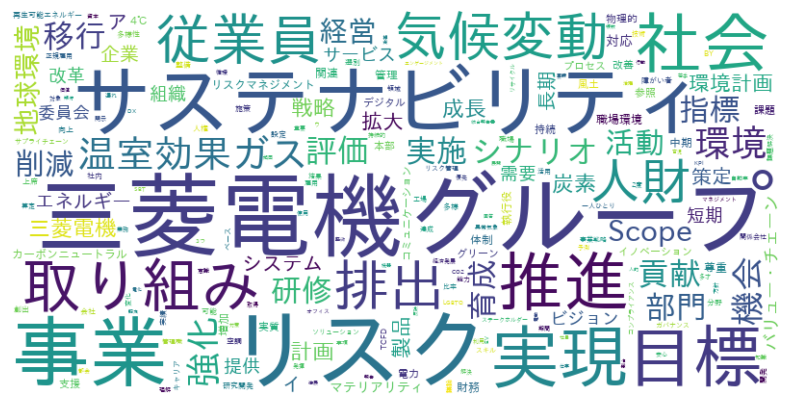

In [11]:
#抽出単語によるワードクラウド作成
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 日本語フォントのパスを指定
jp_font_path = '/usr/share/fonts/opentype/ipaexfont-gothic/ipaexg.ttf'

# ワードクラウドのフォーマット指定
wordcloud = WordCloud(width=800, height=400, background_color='white',font_path=jp_font_path)
# 単語とその頻度を辞書形式に変換
word_freq = {word: freq for word, freq in zip(count_df['単語'], count_df['件数'])}
# ワードクラウドの生成
wordcloud.generate_from_frequencies(word_freq)

# プロット
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 結果をpngファイルに出力
file_name_wordcloud=f'output/{fundcode}_{company_name}_{target_doc_number}_{date_time_string}_WordCloud.png'
wordcloud.to_file(file_name_wordcloud)

In [12]:
#tf-idf用に、ファイル名、企業名、トークンを出力

# データフレームの作成：pdfファイル名とトークンを格納
df_token = pd.DataFrame({"company_name": company_name, "doc_name": target_doc_number, "token": [Merged_Extracted_tokenized_list]})

file_name_token=f'output/{fundcode}_{company_name}_{target_doc_number}_{date_time_string}_Token.csv'
df_token.to_csv(file_name_token, encoding="utf_8_sig", index=False)

In [13]:
#以降、共起分析
#Extracted_page_text（抽出ページ単位のリスト）を、要素一つのリストに集約
#Merged_Extracted_page_text = "\n\n".join(Extracted_page_text)
Merged_Extracted_page_text = "\n\n".join(target_text)


print(tk.noise_eliminator(Merged_Extracted_page_text))

２  サステナビリティに関する考え方及び取組 
 1 サステナビリティ全般
①ガバナンス
ア．サステナビリティの考え方
三菱電機グループは、事業を通じた社会課題の解決という原点に立ち、サステナビリティの実現を経営の根幹に位置づけることを経営方針に掲げています。
社会からの期待や要請・意見を活動に反映させ、社会や環境に与えるネガティブな影響を最小化し、持続可能な社会の実現に向けて取り組んでいます。

イ．サステナビリティの実現に向けた推進事項
サステナビリティの実現に向け、以下の4点を推進事項としています。

価値創出
事業成長と社会の持続可能性を両立させる社会課題解決型事業の創出・発展
基盤強化
三菱電機グループの持続的成長を支える、環境、社会、ガバナンスをはじめとした経営基盤強化
リスク管理
長期的な社会や環境の変化に対するリスクの予測、及び企業経営に与える影響の抑制又は最小化
取組みの開示と対話
透明性の高い情報開示を通じた、社会・顧客・株主・従業員をはじめとするステークホルダーとのコミュニケーションにより、社会からの期待や要請・意見を企業経営に反映
ウ．サステナビリティ推進体制
三菱電機グループは、三菱電機の執行役会議から委嘱を受けたサステナビリティ委員会*
でサステナビリティの取組みに関する方針・計画を決定しています。
サステナビリティ委員会はサステナビリティを担当する上席執行役員が委員長を務め、コーポレート部門で機能別の役割を担当するチーフオフィサーの他、事業部門の執行役等で構成しています。

サステナビリティ委員会での議論の内容は、執行役会議及び取締役会に報告されます。
取締役会では、サステナビリティ経営を三菱電機グループの「重要議題」   から  においては、事業ポートフォリオ戦略、サステナビリティ戦略、人財戦略、ECM/SCM戦略、デジタル戦略 事業DX 、情報システム戦略 業務DX  とし、リスク管理及び収益機会としての観点から十分に議論するとともに、執行役のサステナビリティへの取組み状況についても監督しています。
サステナビリティの取組み推進については、執行役の報酬指標の一つとしており、サステナビリティ・ESG関連領域等非財務事項での業績指標達成度はインセンティブ報酬へ反映しています。

複数部門に関わるサステナビリティ課題に対しては、サステナビ

In [14]:
#集約したテキストを「。」で区切り、形態素解析（共起分析用）
sentences = [tk.mecab_tokenizer(sentence) for sentence in re.split("。", tk.noise_eliminator(Merged_Extracted_page_text))]
#sentences = [tk.mecab_tokenizer(sentence) for sentence in re.split("。|\n", tk.noise_eliminator(Merged_Extracted_page_text))]
print(sentences)

[['サステナビリティ', '考え方', '取組', 'サステナビリティ', '全般', 'ガバナンス', 'ア', 'サステナビリティ', '考え方', '三菱電機グループ', '事業', '社会', '課題', '解決', '原点', 'サステナビリティ', '実現', '経営', '根幹', '経営方針'], ['社会', '期待', '要請', '意見', '活動', '反映', '社会', '環境', 'ネガティブ', '最小', '持続', '可能', '社会', '実現'], ['イ', 'サステナビリティ', '実現', '推進', '事項', 'サステナビリティ', '実現', '4点', '推進', '事項'], ['価値', '創出', '事業', '成長', '社会', '持続可能性', '両立', '社会', '課題解決', '事業', '創出', '発展', '基盤', '強化', '三菱電機グループ', '持続的', '成長', '環境', '社会', 'ガバナンス', '経営基盤', '強化', 'リスク管理', '長期', '社会', '環境', '変化', 'リスク', '予測', '企業', '経営', '抑制', '最小化', '取り組み', '開示', '対話', '透明性', '情報開示', '社会', '顧客', '株主', '従業員', 'ステークホルダー', 'コミュニケーション', '社会', '期待', '要請', '意見', '企業', '経営', '反映', 'ウ', 'サステナビリティ', '推進', '体制', '三菱電機グループ', '三菱電機', '執行役', '会議', '委嘱', 'サステナビリティ', '委員会', 'サステナビリティ', '取り組み', '方針', '計画', '決定'], ['サステナビリティ', '委員会', 'サステナビリティ', '上席', '委員長', 'コーポレート', '部門', '機能', '役割', 'チーフオフィサー', '事業部門', '執行役', '構成'], ['サステナビリティ', '委員会', '議論', '内容', '執行役', '会議', '報告'], ['サステナビリティ', '経営', '三菱電機グループ', '重要', '議題', '事業

In [15]:
#各文中の、形態素組み合わせを作る
sentences_combs = [list(itertools.combinations(sentence,2)) for sentence in sentences]
#print(sentences_combs[0])

#組み合わせた2つの形態素の並びをソート
words_combs = [[tuple(sorted(words)) for words in sentence] for sentence in sentences_combs]
#print(words_combs[0][:30])
target_combs = []
for words_comb in words_combs:
    target_combs.extend(words_comb)
ct = Counter(target_combs)
#print(ct)
df = pd.DataFrame([{"1番目" : i[0][0], "2番目": i[0][1], "count":i[1]} for i in ct.most_common()])

#ファイル出力
file_name_comb = f"output/{fundcode}_{company_name}_{target_doc_number}_{date_time_string}_Co_Occurrence.csv"
df.to_csv(file_name_comb, encoding="utf_8_sig", index=False)

In [16]:
df.head(30)

,1番目,2番目,count
0,サステナビリティ,三菱電機グループ,111
1,三菱電機グループ,三菱電機グループ,103
2,三菱電機グループ,排出,96
3,三菱電機グループ,実現,93
4,三菱電機グループ,改革,86
5,三菱電機グループ,推進,69
6,三菱電機グループ,取り組み,62
7,三菱電機グループ,貢献,61
8,従業員,正規雇用,60
9,三菱電機グループ,従業員,59


In [17]:
#ネットワーク分析の下準備
import networkx as nx
from networkx.algorithms.community import girvan_newman
import network_plot_module as npm
import json

#########################################################
# 分析対象とする共起単語の組み合わせ数（ノード数）を指定
analyzed_links=350
limited_df=df.head(analyzed_links)
#########################################################
# DataFrameからネットワークを作成
G = nx.from_pandas_edgelist(limited_df, '1番目', '2番目', ['count'])


In [18]:
# 各ノードの中心性を計算
try:
    degree_centrality = nx.degree_centrality(G)
except:
    degree_centrality = {node: '' for node in G.nodes()}
    
try:
    betweenness_centrality = nx.betweenness_centrality(G)
except:
    betweenness_centrality = {node: '' for node in G.nodes()}

try:
    closeness_centrality = nx.closeness_centrality(G)
except:
    closeness_centrality = {node: '' for node in G.nodes()}

try:
    eigenvector_centrality = nx.eigenvector_centrality(G)
except:
    eigenvector_centrality = {node: '' for node in G.nodes()}

try:
    katz_centrality = nx.katz_centrality(G)
except:
    katz_centrality = {node: '' for node in G.nodes()}

# Girvan-Newmanアルゴリズムでコミュニティに分割
comp = girvan_newman(G)
communities = tuple(sorted(c) for c in next(comp))

# 各ノードがどのコミュニティに属するかを記録
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i

# 中心性を新しいデータフレームに格納
centrality_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Degree Centrality': [degree_centrality[node] for node in G.nodes()],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes()],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes()],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes()],
#    'Katz Centrality': [katz_centrality[node] for node in G.nodes()],
    'Community': [community_map[node] for node in G.nodes()]  # コミュニティ情報を追加
    })
#print(centrality_df)

file_name_comb = f"output/{fundcode}_{company_name}_{target_doc_number}_{date_time_string}_Centrality_{analyzed_links}.csv"
centrality_df.to_csv(file_name_comb, encoding="utf_8_sig", index=False)

In [19]:
#ネットワーク図を描画、ファイル出力
got_net = npm.kyoki_word_network(limited_df)
#フィルタボタンを表示させる場合は、set_optionを無効にする必要あり
#got_net.show_buttons(filter_=['physics'])
got_net.set_options("""
const options = {
  "physics": {
    "forceAtlas2Based": {
      "centralGravity": 0.1,
      "springLength": 25,
      "springConstant": 0.1
    },
    "minVelocity": 0.75,
    "solver": "forceAtlas2Based"
  }
}
""")
file_name_kyoki = f'output/{fundcode}_{company_name}_{target_doc_number}_{date_time_string}_kyoki_{analyzed_links}.html'
got_net.show(file_name_kyoki)

In [20]:
#処理した条件をテキストファイルに出力
file_name_condition=f'output/{fundcode}_{company_name}_{target_doc_number}_{date_time_string}_Condition.txt'

# ファイルを書き込みモードで開く
with open(file_name_condition, 'w') as file:
    # 各変数の値をテキストファイルに書き込む
    file.write(f"fundcode = {fundcode}\n")
    file.write(f"Company name = {company_name}\n")
    file.write(f"target_doc_number = {target_doc_number}\n")
